<a href="https://colab.research.google.com/github/from-iqwerty-import-IQ/Deep_Learning_Projects/blob/main/Copy_of_Handwritten_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [2]:
!kaggle datasets download -d landlord/handwriting-recognition

100% 1.26G/1.26G [00:08<00:00, 215MB/s]
100% 1.26G/1.26G [00:08<00:00, 162MB/s]


In [3]:
!unzip '/content/handwriting-recognition.zip'

Streaming output truncated to the last 5000 lines.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/VALIDATION_

### Importing all the libraries

In [4]:
!pip install np_utils

     |████████████████████████████████| 61 kB 4.2 MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57131 sha256=f5ce3a44a19ac25596bb4e7f39f0113d0669ee12c98562be3f298e79e053f1fd
  Stored in directory: /root/.cache/pip/wheels/8c/4e/ef/095c24693723c329f4cdc1079861cdbb2487d4b41b2496a4e7
Successfully built np-utils


In [5]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout,Input,Reshape,Bidirectional,LSTM,Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [6]:
dir = "/content/train_v2"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])




In [7]:
print(train_data)

[[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 'train'], [array([[ 30, 254, 255, ..., 255, 255, 255],
       [ 52, 255, 253, ..., 255, 255, 255],
       [178, 249, 254, ..., 255, 255, 255],
       ...,
       [ 29, 255, 255, ..., 255, 255, 255],
       [ 96, 255, 255, ..., 255, 255, 255],
       [219, 255, 255, ..., 255, 255, 255]], dtype=uint8), 'train'], [array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 'train'], [array([[254, 254, 252, ..., 255, 255, 255],
       [254, 250, 254, ..., 255, 255, 255],
    

In [8]:
train = pd.read_csv('/content/written_name_train_v2.csv')
valid = pd.read_csv('/content/written_name_validation_v2.csv')

In [9]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


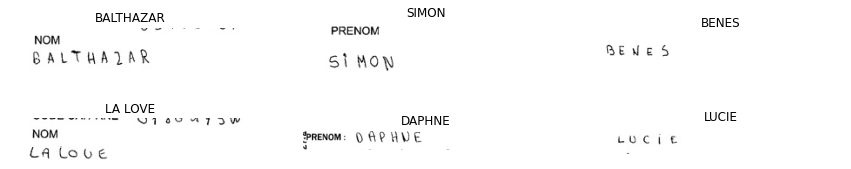

In [10]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/train_v2/train/'+train.loc[i, 'FILENAME']
    #img_dir =''
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [11]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [12]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

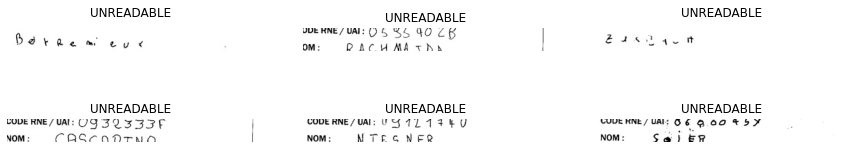

In [13]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [14]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [15]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [16]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [17]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [18]:
train_x = []
train_size = 50000

for i in range(train_size):
    img_dir = '/content/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [19]:
valid_size = 5000

In [20]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [21]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [45]:
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [46]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [47]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1]) 
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])] = label_to_num(train.loc[i, 'IDENTITY'])  


In [48]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])  

In [49]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 64, 32)       128       
_________________________________________________________________
activation_3 (Activation)    (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 32, 64)       256 

In [50]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [51]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [52]:
from tensorflow.keras.optimizers import Adam

In [53]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=10, batch_size=64)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
782/782 [==============================] - 71s 83ms/step - loss: 21.2087 - val_loss: 19.6586
Epoch 2/10
782/782 [==============================] - 63s 80ms/step - loss: 18.6137 - val_loss: 17.6953
Epoch 3/10
782/782 [==============================] - 63s 81ms/step - loss: 13.8867 - val_loss: 10.2494
Epoch 4/10
782/782 [==============================] - 63s 80ms/step - loss: 7.9590 - val_loss: 5.7269
Epoch 5/10
782/782 [==============================] - 63s 80ms/step - loss: 5.1973 - val_loss: 4.4173
Epoch 6/10
782/782 [==============================] - 63s 80ms/step - loss: 4.0949 - val_loss: 3.4321
Epoch 7/10
782/782 [==============================] - 63s 80ms/step - loss: 3.4801 - val_loss: 2.9309
Epoch 8/10
782/782 [==============================] - 63s 80ms/step - loss: 3.0867 - val_loss: 2.7119
Epoch 9/10
782/782 [==============================] - 63s 80ms/step - loss: 2.7915 - val_loss: 2.4570
Epoch 10/10
782/782 [==============================] - 63s 80ms/step - loss:

In [54]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [55]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 66.68%
Correct words predicted      : 50.72%


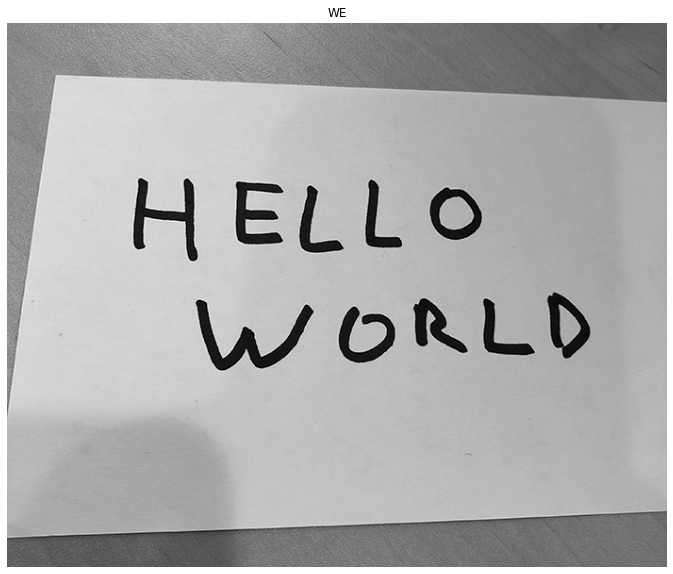

In [64]:
test = pd.read_csv('/content/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))

img_dir = '/content/hello_world.png'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
    
image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [61]:
!wget "https://thumbs.dreamstime.com/z/erasing-hope-hand-written-word-blackboard-being-erased-concept-180674737.jpg"

--2021-09-26 08:06:58--  https://thumbs.dreamstime.com/z/erasing-hope-hand-written-word-blackboard-being-erased-concept-180674737.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.163.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.163.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 436732 (426K) [image/jpeg]
Saving to: ‘erasing-hope-hand-written-word-blackboard-being-erased-concept-180674737.jpg’

erasing-hope-hand-w 100%[===================>] 426.50K  --.-KB/s    in 0.03s   

2021-09-26 08:06:58 (14.9 MB/s) - ‘erasing-hope-hand-written-word-blackboard-being-erased-concept-180674737.jpg’ saved [436732/436732]

